In [1]:
# Preface
import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
import numpy as np
from os.path import isdir
from os import makedirs

from collections import OrderedDict

%config Completer.use_jedi = False

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sys import path as syspath
syspath.append("./functions/")

from physio_def_1 import *

In [2]:
pathToFile = '//s2/physio/team/slakrupnik/project/experiments/Sandra/20190812/Experiment28.lif'

md = bf.get_omexml_metadata(pathToFile)
xml = bf.OMEXML(md)
Nimages = xml.get_image_count()
rdr = bf.ImageReader(pathToFile, perform_init=True)
extension = "."+pathToFile.split(".")[-1]

OrderedDict([(i,xml.image(i).Name) for i in range(Nimages)])

OrderedDict([(0, 'Image005'),
             (1, 'Image008'),
             (2, 'Image011'),
             (3, 'Image013'),
             (4, 'Series015'),
             (5, 'Image019'),
             (6, 'Image021'),
             (7, 'Series022'),
             (8, 'Image026'),
             (9, 'Image033'),
             (10, 'Series034'),
             (11, 'Image040'),
             (12, 'Series041'),
             (13, 'Series042'),
             (14, 'Image044'),
             (15, 'Image047'),
             (16, 'Image049'),
             (17, 'Image051'),
             (18, 'Series052'),
             (19, 'Series053'),
             (20, 'Series054'),
             (21, 'Series055'),
             (22, 'Series056'),
             (23, 'Series057'),
             (24, 'Series059'),
             (25, 'Image061'),
             (26, 'Series062'),
             (27, 'Image069'),
             (28, 'Series070'),
             (29, 'Series071'),
             (30, 'Image078'),
             (31, 'Series079'),
  

In [3]:
iSeries = 12

im = xml.image(iSeries)
Name = im.Name
dimensions = dict(zip("TXY",(getattr(im.Pixels, "Size"+dim) for dim in "TXY")))

if dimensions["T"]>1:
    dimensions['freq'] = getApparentFreq(iSeries,xml)

In [4]:
dimensions

{'T': 8000, 'X': 512, 'Y': 512, 'freq': 1.981011120610266}

In [5]:
image = importFrames(rdr,idx=iSeries, which=(100,)).mean(axis=0)

In [6]:
from plotFirst_1 import plotImage

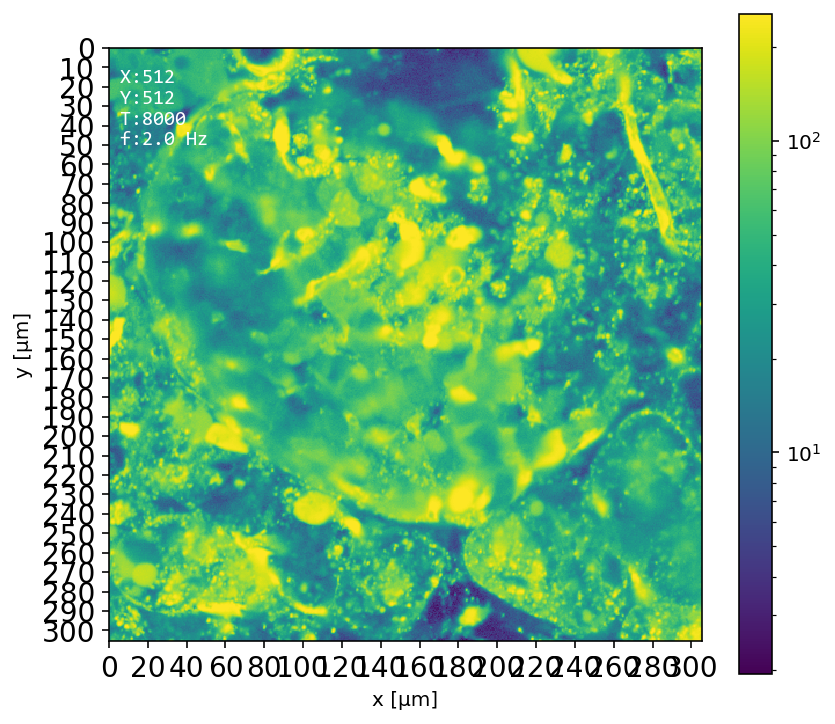

In [7]:
pxSize = im.Pixels.get_PhysicalSizeX()
pxUnit = im.Pixels.get_PhysicalSizeXUnit()

text = "\n".join([" %s:%i"%(c,dimensions[c])  for c in "XYT"])

if dimensions["T"]>1:
    text += "\n f:%.1f Hz"%dimensions['freq']

plotImage(image.T,pxSize=pxSize,pxUnit=pxUnit,
          rescale=1./50,
          #savePath=saveDir+outName,
          addInfo=text)
plt.tight_layout()

In [10]:
image.shape

(512, 512)

In [12]:
from matplotlib.colors import LogNorm

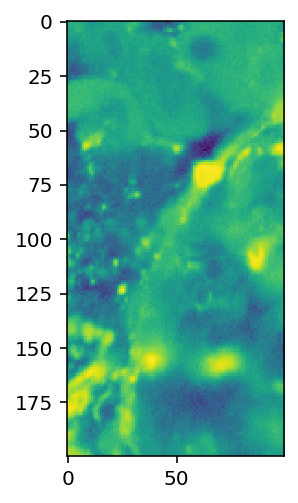

In [14]:
plt.imshow(image[:100,:200].T, norm=LogNorm())

In [15]:
plotImageWithRois([(70,150)],20,image_=)

AttributeError: 'NoneType' object has no attribute 'shape'

# Choose a patch to import all

In [20]:
%%time
subimage = importFrames(
    rdr,
    idx=iSeries,
    which=(dimensions["T"]//10,(70,85),(150,165))
                       )

Wall time: 15.7 s


In [21]:
time = getTimes(xml_=xml,idx_=iSeries)[:len(subimage)]

In [22]:
pxSize

0.5962577299412916

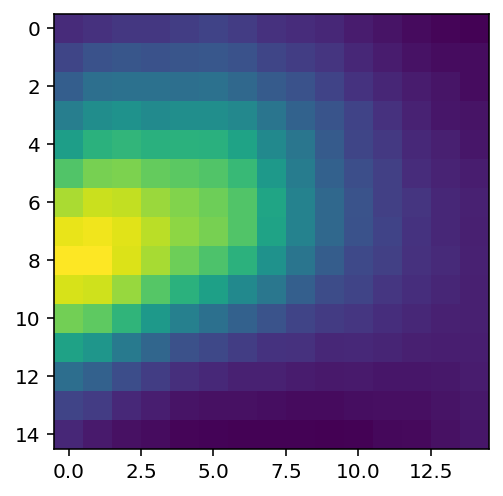

In [23]:
plt.imshow(subimage.mean(0).T)

In [25]:
subimage.shape

(800, 15, 15)

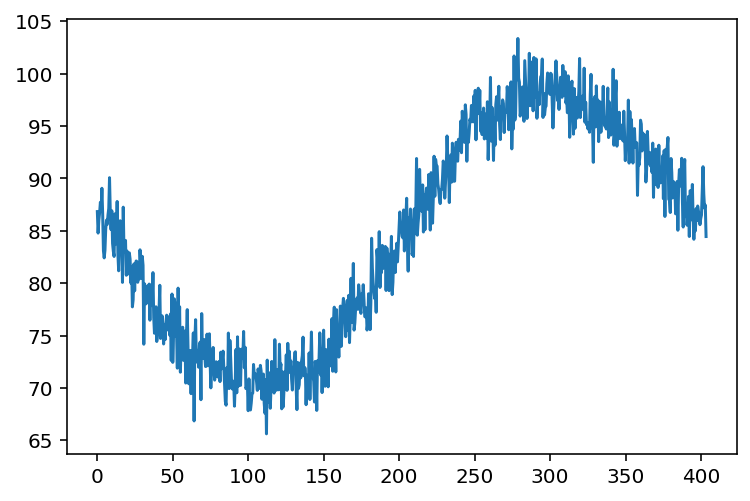

In [26]:
plt.plot(time,subimage.mean(axis=(1,2)))

In [28]:
pxWin=3
pxShows = [(i*pxWin,j*pxWin) for i in range(subimage.shape[1]//pxWin) for j in range(subimage.shape[2]//pxWin)]
# pxShows = []

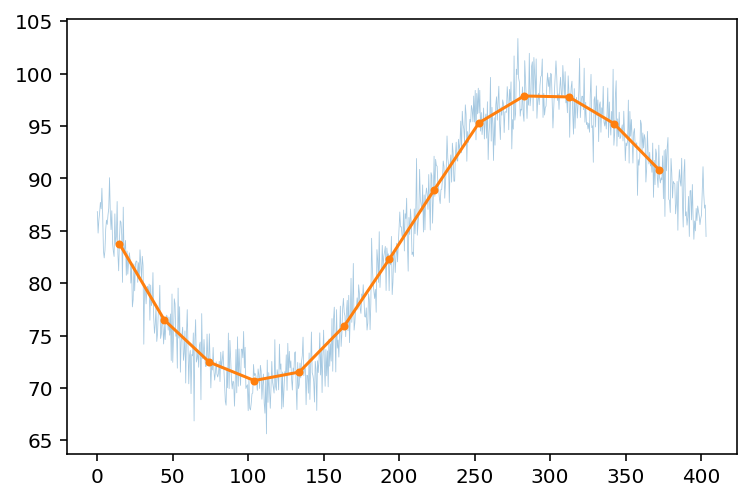

In [31]:
slowTimescale = 30 # in seconds
tWin=int(slowTimescale*dimensions["freq"])

plt.plot(time,subimage.mean(axis=(1,2)), lw=.4,alpha=.4)
plt.plot(rebin(time,tWin),rebin(subimage.mean(axis=(1,2)),tWin),".-")

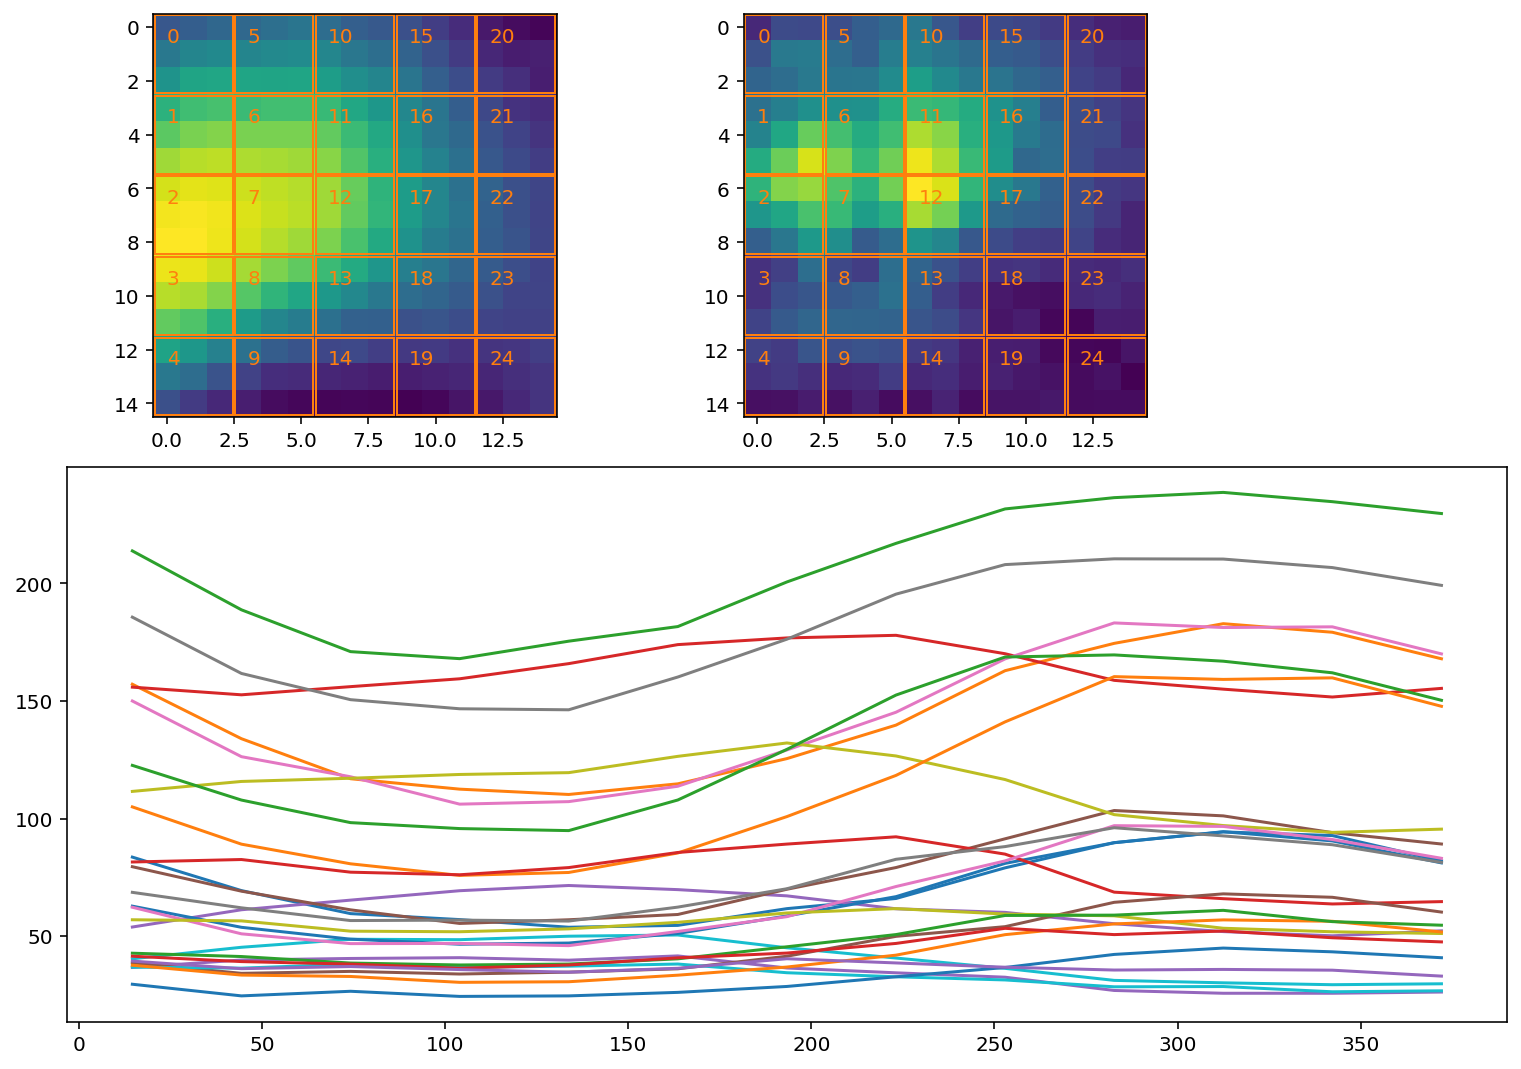

In [32]:
# fig, axs = plt.subplots(1,2,figsize=(10,3))
fig = plt.figure(figsize=(10,7))

axsUp = [
    fig.add_axes([0,.6,.4,.4]),
    fig.add_axes([.41,.6,.4,.4])
]
plotImageWithRois(
            pxShows = pxShows,
            pxWin   = pxWin,
            image_=rebin(subimage[:,:,:],tWin),
            stdDev=True,
            axs =axsUp,
            label=True
        );

roiProfiles = getRoiProfiles(image_=subimage,pxShows=pxShows,pxWin=pxWin,tWin_=tWin)

ax = fig.add_axes([0,0,1,.55])
for roiLabel in roiProfiles:
    ax.plot(rebin(time,tWin),roiProfiles[roiLabel], label=roiLabel)

# ax.legend(ncol=len(roiProfiles)//20+1)

In [33]:
X = np.vstack(list(roiProfiles.values()))
X.shape

(25, 13)

In [34]:
CorrCoefRaw = np.corrcoef(X)

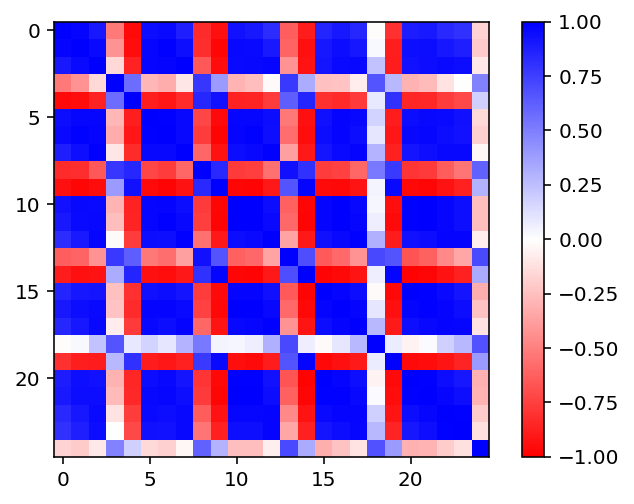

In [35]:
plt.imshow(CorrCoefRaw,vmin=-1,vmax=1,cmap="bwr_r")
plt.colorbar()

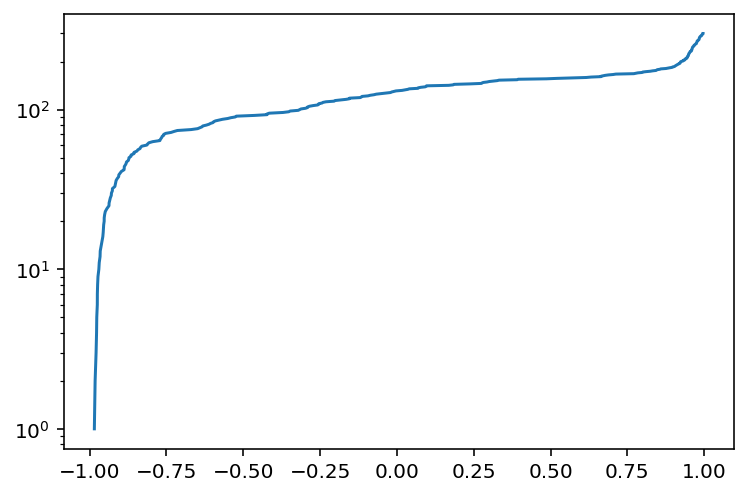

In [36]:
x = CorrCoefRaw[np.triu_indices_from(CorrCoefRaw,1)]
plt.plot(sorted(x),np.arange(len(x))+1)
plt.yscale("log")

# Choose some extremes to show

In [37]:
indices = np.triu_indices_from(CorrCoefRaw)
tmp = indices+(CorrCoefRaw[indices],)
tmp = list(zip(*tmp))

In [38]:
tmp = sorted(tmp,key=lambda xi: xi[-1])

In [39]:
interestinPairs = np.array(tmp)[:,:2].astype(int)

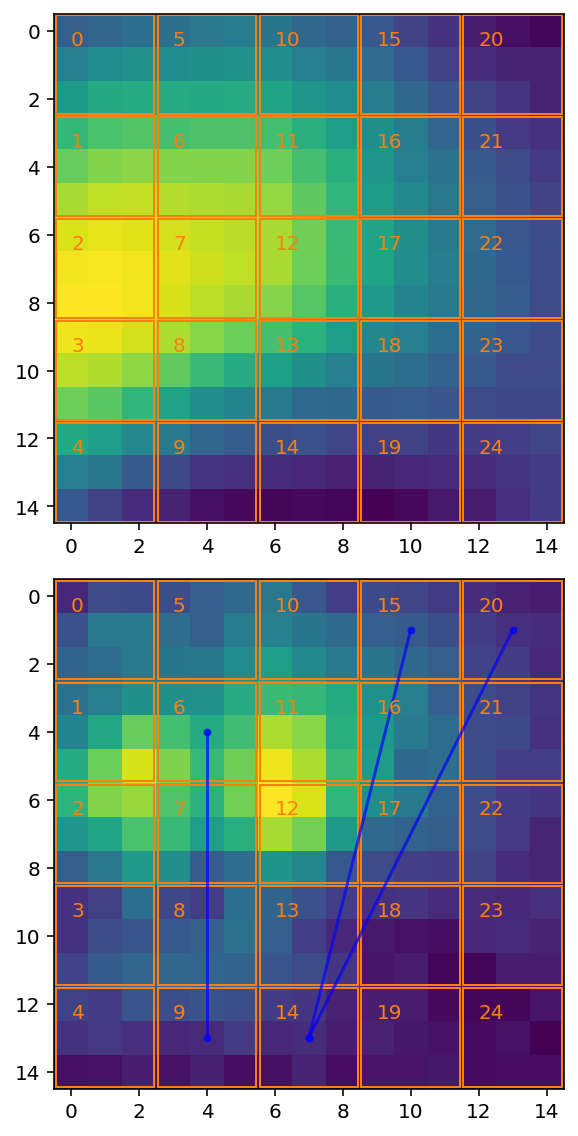

In [40]:
plotImageWithRois(pxShows,pxWin,image_=rebin(subimage,tWin)*100,imgHeight=4,stdDev=True);
for i,j in interestinPairs[:3]:
    if j<=i: continue
    v = CorrCoefRaw[i,j]
    x,y = np.array(pxShows[i])-.5+pxWin/2,np.array(pxShows[j])-.5+pxWin/2
    c = plt.cm.bwr((v+1)/2)
    plt.plot(*np.array([x,y]).T,marker=".",color=c,alpha = .7)
plt.tight_layout()
# plt.savefig("C:/Users/sarikass/Downloads/anticorr_representation.png",dpi=150)

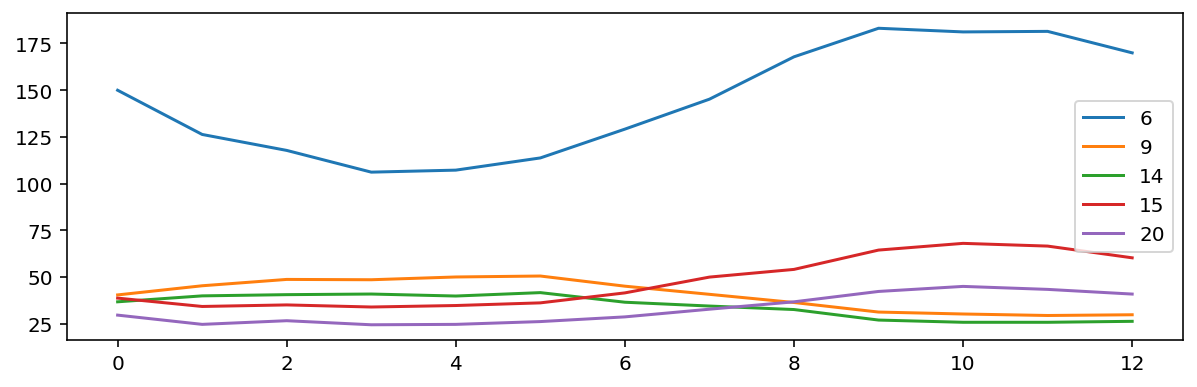

In [41]:
plt.figure(figsize=(10,3))
for roiLabel in np.unique(interestinPairs[:3]):
    plt.plot(X[roiLabel], label=roiLabel)
plt.legend()

In [42]:
### preprocessing
from sklearn import preprocessing

In [43]:
# subtractMeanScaler = preprocessing.FunctionTransformer(func=lambda xi: xi-xi.mean())
# normalizeScaler    = preprocessing.FunctionTransformer(func=lambda xi: (xi-xi.mean())/xi.std())

In [44]:
from matplotlib.colors import LogNorm

In [45]:
normalizer = preprocessing.Normalizer()

In [46]:
absMax = image.max()

In [47]:
subimage[subimage==absMax]=np.nan

In [48]:
# # mm_scaler = preprocessing.RobustScaler()
# mm_scaler = preprocessing.Normalizer()#MinMaxScaler()#
# ppX = mm_scaler.fit_transform(X)

# plt.figure(figsize=(13,4))

# plt.subplot(1,3,2)
# plt.hist(ppX[::10,:].T, 30,histtype="step");#filled", alpha = .3);


# plt.subplot(1,3,1)
# plt.imshow(X)
# plt.gca().set_aspect("auto")


# plt.subplot(1,3,3)
# plt.imshow(ppX)
# plt.gca().set_aspect("auto")

# Try clusterning

In [49]:
import scipy.cluster.hierarchy as spc

In [50]:
def showLinkageAndMatrices(linkage_,matrices_, figsize=5, fig=None, axs=None,threshold=None,scale=1):
    add = .3
    if fig is None:
        fig = plt.figure(figsize=np.array([len(matrices_)+0.15+add,1])*figsize)
    if axs is None:
        gs = fig.add_gridspec(1, len(matrices_)*2+1)
        axDnd = fig.add_subplot(gs[:1])
        axs = [axDnd]
        axs += [fig.add_subplot(gs[i*2+1:i*2+3], sharey=axDnd) for i in range(len(matrices_))]
    else:
        axDnd = axs[0]
        
    Z = linkage_.copy()
    Z[:,-2] *= scale
    dnd_ = spc.dendrogram(Z,
                         color_threshold=threshold*scale if threshold is not None else None,
                         ax=axDnd,
                         orientation="left")
#     if threshold is not None:
#         axDnd.axvline(threshold*scale,color="grey",lw=.6)
#     if scale>1:
#         axDnd.set_xscale("symlog")
#         xt = axDnd.get_xticks()
#         axDnd.set_xticklabels(xt/scale)
    rightOrder = dnd_["leaves"][::-1]
    ia = 1
    if "corr" in matrices_:
        D = matrices_["corr"][rightOrder].copy()
        D = D[:,rightOrder]
        ax = axs[ia]
        ax.imshow(D, vmin=-1,vmax=1,cmap="bwr_r", extent=(-.5,D.shape[0]-.5,)+axDnd.get_ylim())
        ax.set_title("corr. coefs")
        ax.set_aspect("auto")
        plt.setp(ax.get_yticklabels(), visible=False)
        ia += 1
    if "orig" in matrices_:
        X_ = matrices_['orig']
        ax = axs[ia]
        ax.imshow(X_[rightOrder],origin="bottom", extent=(-.5,X_.shape[1]-.5,)+axDnd.get_ylim())
        ax.set_aspect("auto")
        ax.set_title("time profiles")
    return dnd_

In [51]:
ppX = normalizer.fit_transform(X)

In [52]:
# x = ppX[:]
# Ncl = 3

# for method in ["single",'complete',"average","centroid","weighted","ward",]:
#     for metric in ["cityblock","correlation","euclidean","jensenshannon","mahalanobis"]:
#         try:
#             Z = spc.linkage(x, method=method, metric=metric)
#         except:
#             continue
#         fig = plt.figure(figsize=(15,4))
#         fig.suptitle(f"{method} {metric}"+" "*10)
#         gs=fig.add_gridspec(1, 7, )
#         myaxs = [fig.add_subplot(gs[:1])]
#         myaxs += [fig.add_subplot(gs[i*2+1:i*2+3], sharey=myaxs[0]) for i in range(2)]
#         dnd = showLinkageAndMatrices(Z,matrices_ = {"orig":x,"corr":CorrCoefRaw},axs=myaxs,threshold=Z[-Ncl+1,2])
#         ax = fig.add_subplot(gs[-2:])
#         clrs = OrderedDict()
#         for jj,c in zip((np.array(dnd['icoord'])[:,1:3]-5)/10,dnd["color_list"]):
#             for j in jj:
#                 if int(j)!=j or j>=len(x): continue
#                 k=dnd['leaves'][int(j)]
#                 if k in clrs: continue
#                 clrs[k] = c

#         ax.imshow(subimage.mean(axis=0).T,cmap="Greys",vmax=1000)
#         for j,c in clrs.items():
#             ax.plot(*(np.array(pxShows[j])-.5+pxWin/2),marker="s",c=c,alpha=.2,ms=20)
#             ax.plot(*(np.array(pxShows[j])-.5+pxWin/2),marker="s",mfc="none",mec=c,ms=20)
#         #     ax.text(*(np.array(pxShows[j])-.5+pxWin/2),s=j,color=c,ha="center",va='center')
#         fig.savefig(f"figures/{method}_{metric}_1.png")
#         plt.close(fig);

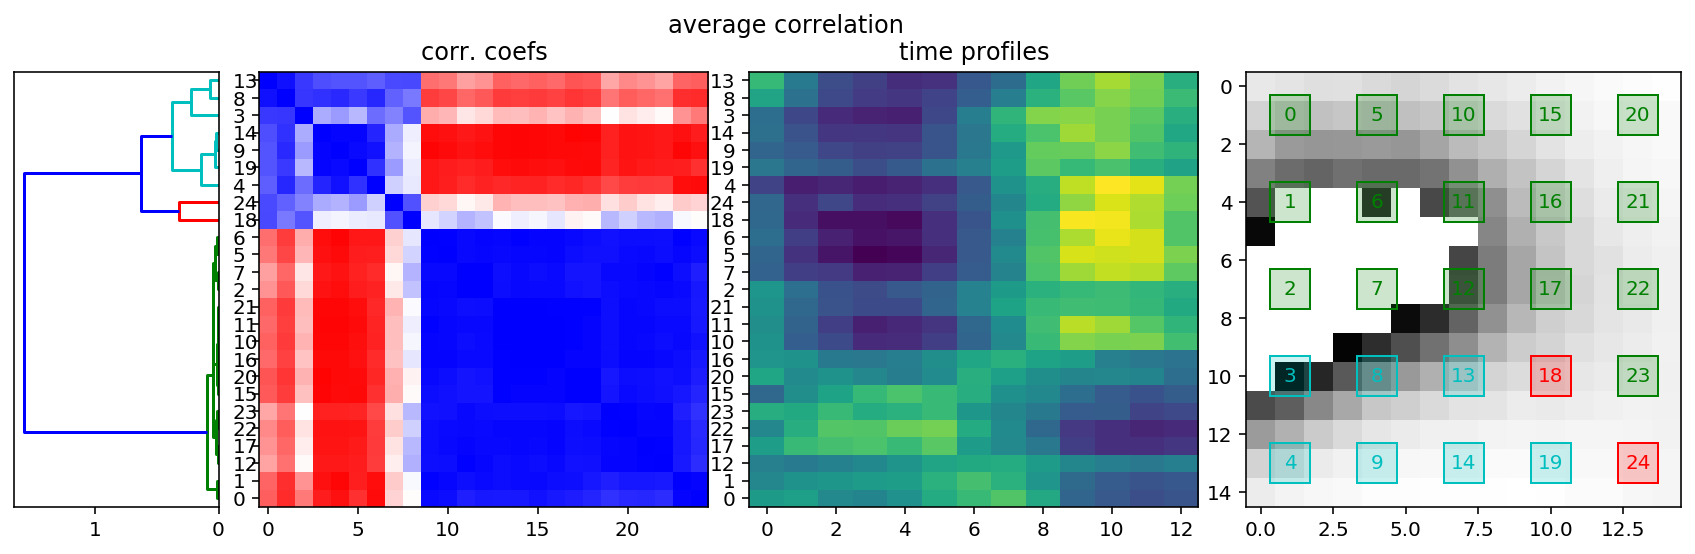

<Figure size 882x360 with 0 Axes>

In [53]:
x = ppX[:]
Ncl = 3

method = "average"
metric = "correlation"
Z = spc.linkage(x, method=method, metric=metric)
fig = plt.figure(figsize=(15,4))
fig.suptitle(f"{method} {metric}"+" "*10)
gs=fig.add_gridspec(1, 7, )
myaxs = [fig.add_subplot(gs[:1])]
myaxs += [fig.add_subplot(gs[i*2+1:i*2+3], sharey=myaxs[0]) for i in range(2)]
dnd = showLinkageAndMatrices(Z,matrices_ = {"orig":x,"corr":CorrCoefRaw},axs=myaxs,threshold=Z[-Ncl+1,2])
ax = fig.add_subplot(gs[-2:])
clrs = OrderedDict()
for jj,c in zip((np.array(dnd['icoord'])[:,1:3]-5)/10,dnd["color_list"]):
    for j in jj:
        if int(j)!=j or j>=len(x): continue
        k=dnd['leaves'][int(j)]
        if k in clrs: continue
        clrs[k] = c

ax.imshow(subimage.mean(axis=0).T,cmap="Greys",vmax=None)
for j,c in clrs.items():
    ax.plot(*(np.array(pxShows[j])-.5+pxWin/2),marker="s",c=c,alpha=.2,ms=20)
    ax.plot(*(np.array(pxShows[j])-.5+pxWin/2),marker="s",mfc="none",mec=c,ms=20)
    ax.text(*(np.array(pxShows[j])-.5+pxWin/2),s=j,color=c,ha="center",va='center')


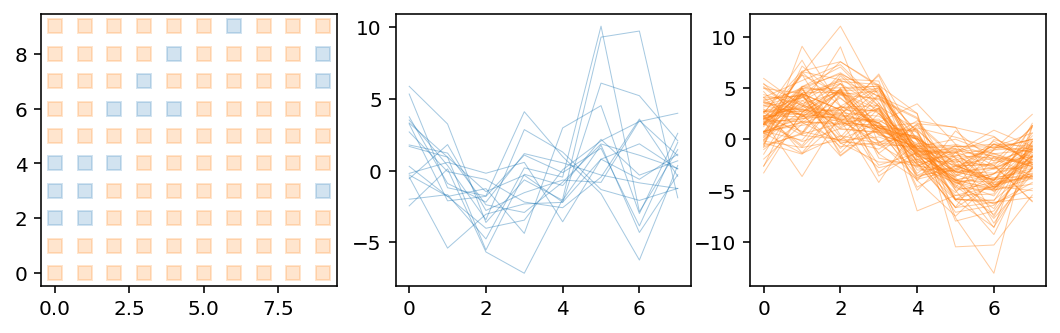

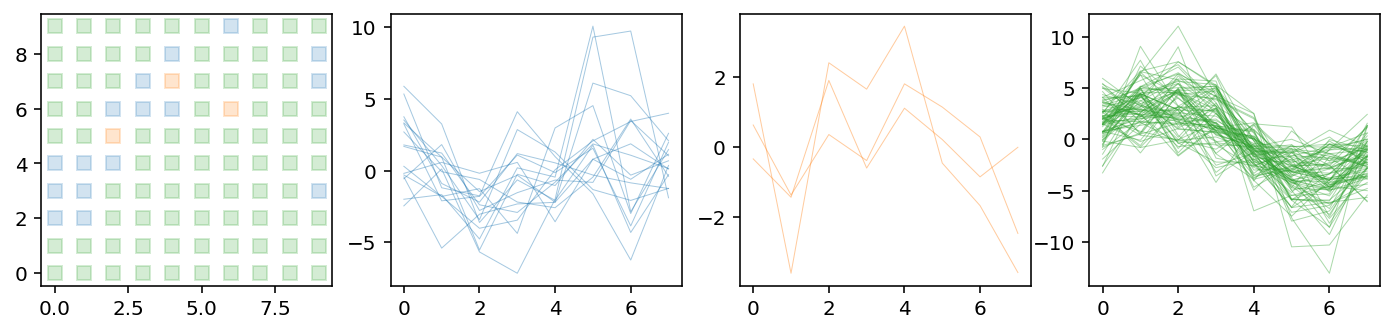

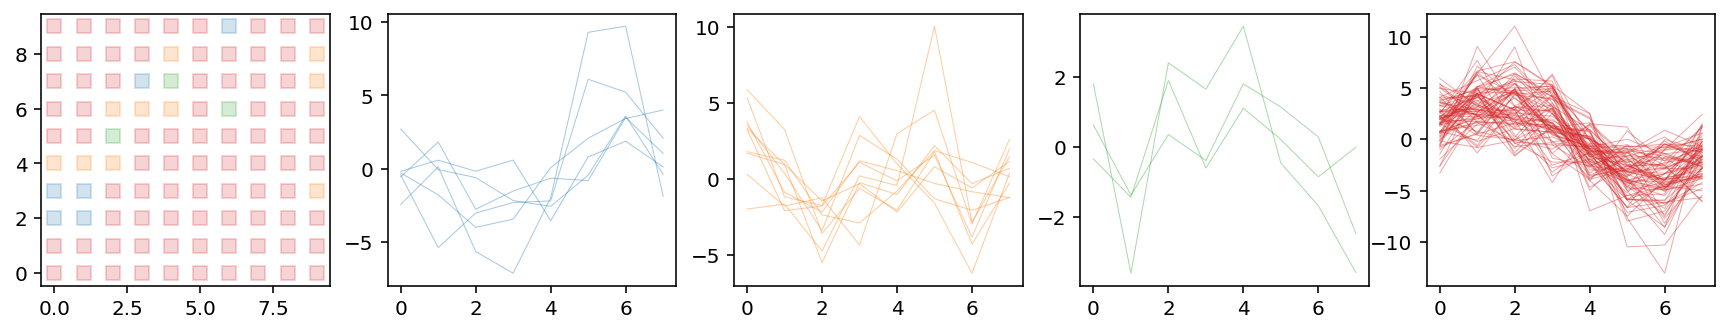

In [106]:
for ncl in [2,3,4]:
    ids = spc.fcluster(Z,criterion="maxclust",t=ncl)
    fig, axs = plt.subplots(1,ncl+1,figsize=(3*(ncl+1),2.5), sharey=False)
    ax0 = axs[0]
    # ax0.imshow(subimage.mean(axis=0).T,cmap="Greys",vmax=None)

    for i, ax in enumerate(axs[1:]):
    #     ax=axs[0]
        fltr = ids==(i+1)
        c = "C%i"%(i)
        for x in X[fltr]: 
            ax.plot(x-x.mean(),color=c,lw=.5,alpha = .4)
        x,y = np.array(pxShows)[fltr].T-.5+pxWin/2
        ax0.plot(x,y,"s",c=c,alpha=.2,ms=7)
#     ax.plot(*(np.array(pxShows[j])-.5+pxWin/2),marker="s",c=c,alpha=.2,ms=20)
#     ax.plot(*(np.array(pxShows[j])-.5+pxWin/2),marker="s",mfc="none",mec=c,ms=20)
#     ax.text(*(np.array(pxShows[j])-.5+pxWin/2),s=j,color=c,ha="center",va='center')

In [54]:
fltr

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False])

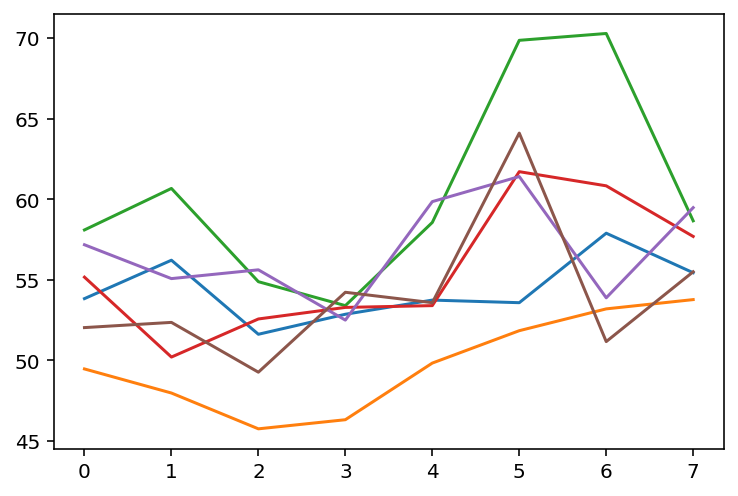

In [43]:
for i in [52,62,53,63,54,64]:
    plt.plot(X[i])

# PCA

In [328]:
def myPCA(data):
    '''
    Input:  2D numpy array where rows are observations
    Output: a tuple Eigenvalues, Eigenvetors
    '''
    from scipy import linalg as la
    C = np.cov(data, rowvar=False)
    vals, vecs = la.eigh(C)
    vals = vals[::-1]
    vecs = vecs.T[::-1]
    datamean = data.mean(axis=0)
    for i in range(len(vals)):
        if datamean.dot(vecs[i])<0:
            vecs[i] = -vecs[i]
    return vals, vecs

In [329]:
def project(observation, vecs, obsmean = 0):
    return obsmean+np.sum([observation.dot(v)*v for v in vecs], axis=0)

In [330]:
import pandas as pd

In [340]:
vals, vecs = myPCA(ppX)
# vals, vecs = myPCA(ppX)

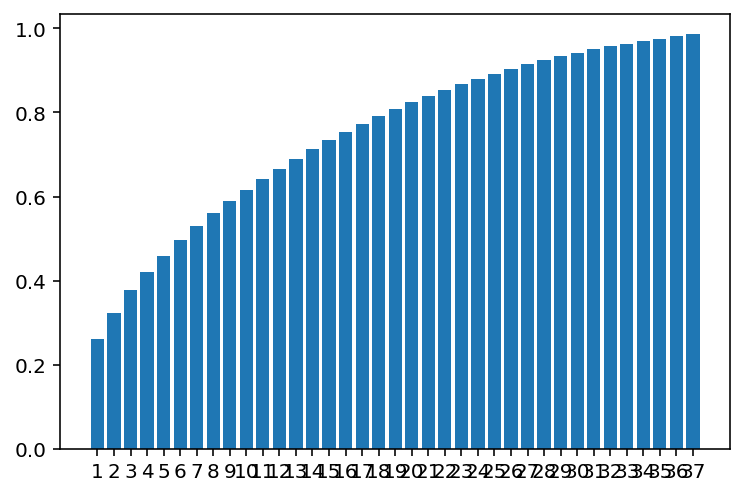

In [341]:
percVarExplained = np.cumsum(vals/sum(vals))
nComponents = np.where(percVarExplained<.99)[0][-1]
plt.bar(np.arange(nComponents)+1,percVarExplained[:nComponents])
plt.xticks(np.arange(nComponents)+1);

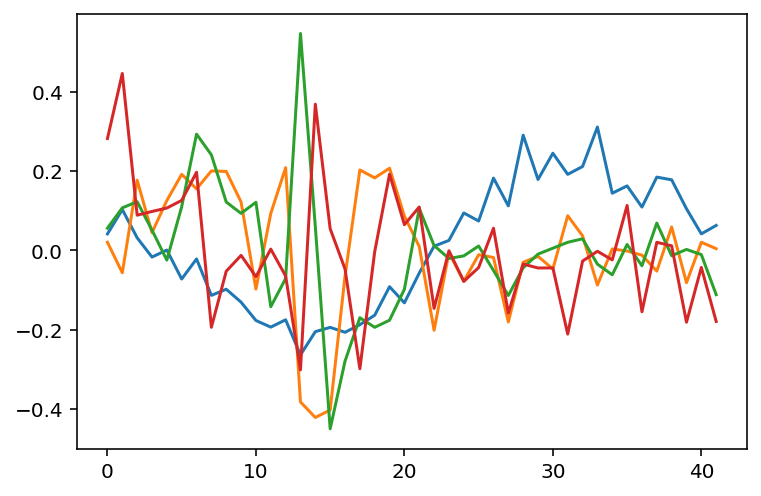

In [342]:
plt.plot(vecs[:min(nComponents,4),:].T)

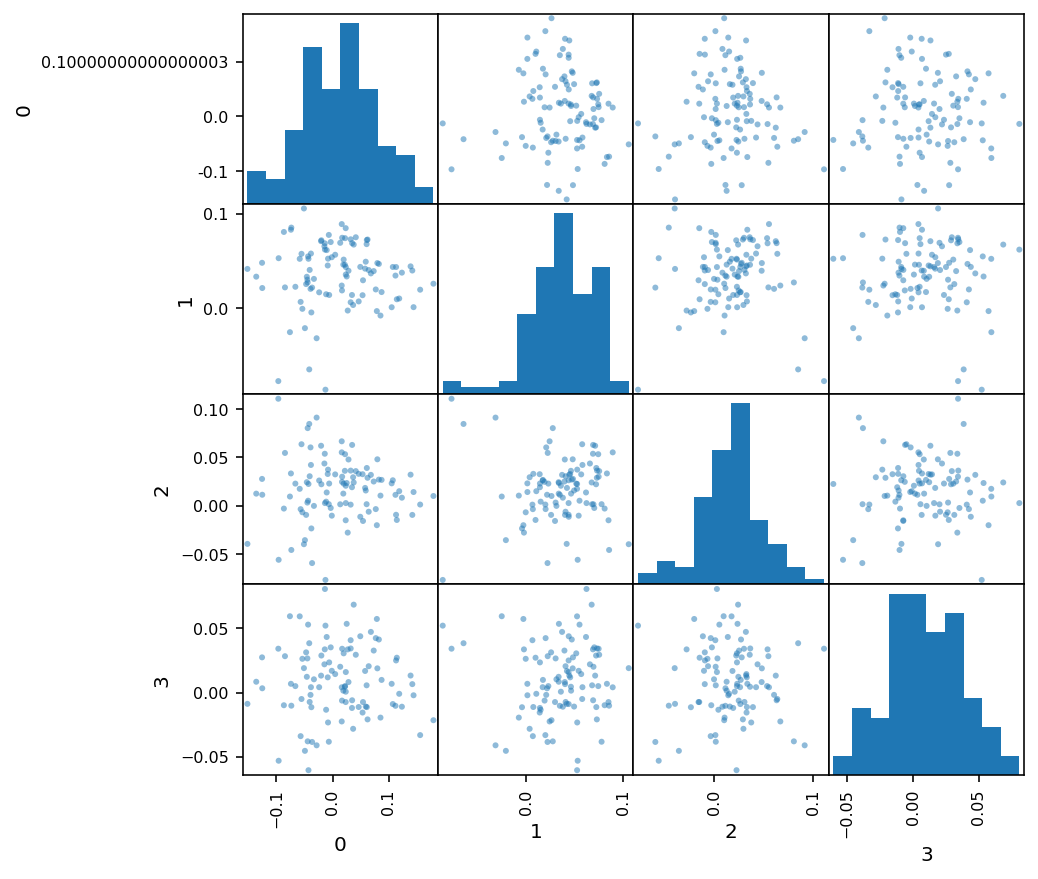

In [355]:
pd.plotting.scatter_matrix(pd.DataFrame(projections),figsize=(7,7));

In [357]:
projections.shape

(100, 3)

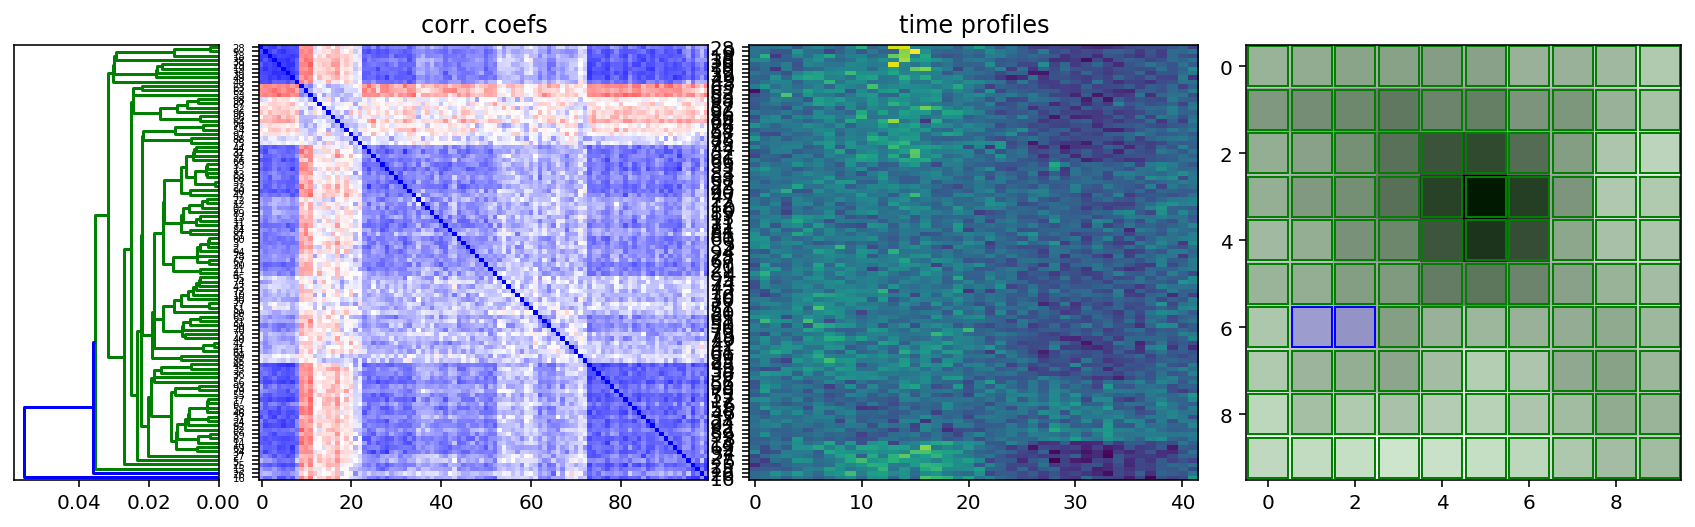

<Figure size 882x360 with 0 Axes>

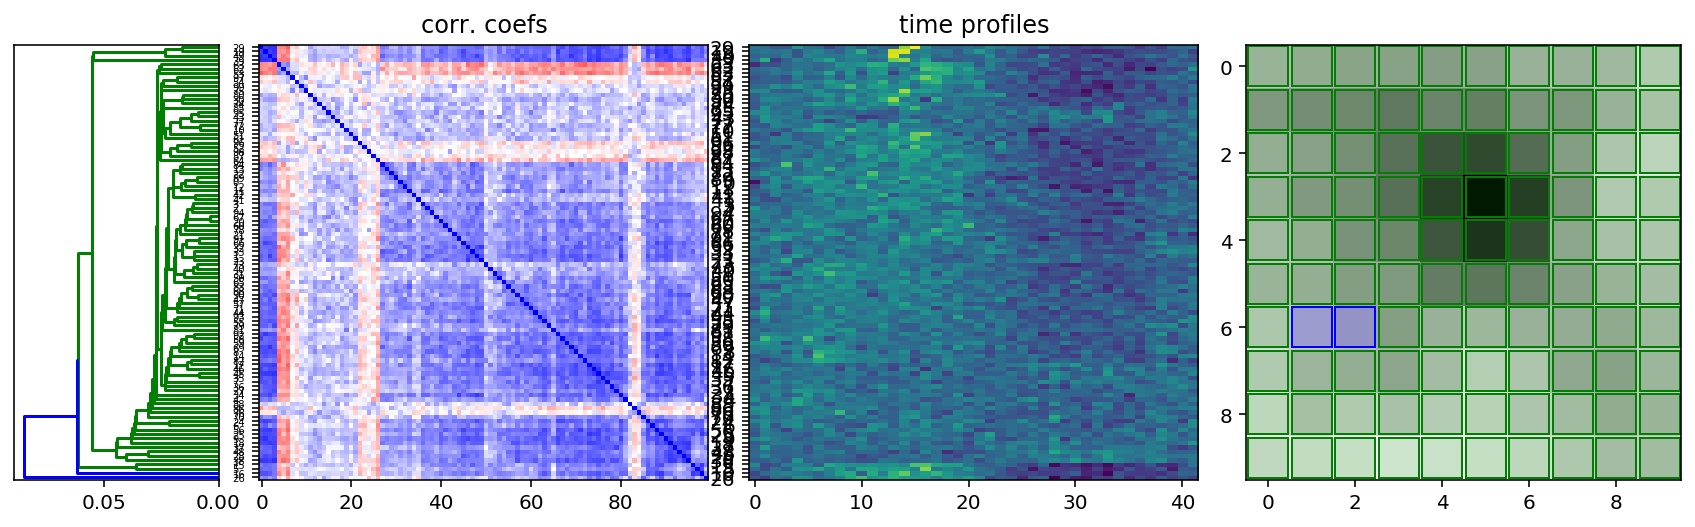

<Figure size 882x360 with 0 Axes>

In [362]:
MtoPCA = ppX.copy()
vals, vecs = myPCA(ppX)
Ncl = 3
for nComponents in [2,3]:
    projections = np.array([[t.dot(vecs[j]) for j in range(nComponents)] for t in MtoPCA])
#     proj = normalizer.fit_transform(projections.T).T
    proj = projections
    linkage = spc.linkage(proj, method='single', metric="euclidean")
    
    fig = plt.figure(figsize=(15,4))
    gs=fig.add_gridspec(1, 7, )
    myaxs = [fig.add_subplot(gs[:1])]
    myaxs += [fig.add_subplot(gs[i*2+1:i*2+3], sharey=myaxs[0]) for i in range(2)]
    dnd = showLinkageAndMatrices(linkage,matrices_ = {"orig":MtoPCA,"corr":CorrCoefRaw},axs=myaxs,threshold=linkage[-Ncl+1,2])
    ax = fig.add_subplot(gs[-2:])
    clrs = OrderedDict()
    for jj,c in zip((np.array(dnd['icoord'])[:,1:3]-5)/10,dnd["color_list"]):
        for j in jj:
            if int(j)!=j or j>=len(x): continue
            k=dnd['leaves'][int(j)]
            if k in clrs: continue
            clrs[k] = c

    ax.imshow(subimage.mean(axis=0).T,cmap="Greys",vmax=None)
    for j,c in clrs.items():
        ax.plot(*(np.array(pxShows[j])-.5+pxWin/2),marker="s",c=c,alpha=.2,ms=20)
        ax.plot(*(np.array(pxShows[j])-.5+pxWin/2),marker="s",mfc="none",mec=c,ms=20)
    
#     axDnd = fig.add_axes([0,0,add*.8,1])
#     dnd = spc.dendrogram(linkage,ax=axDnd, orientation="left",color_threshold=4);
#     ax  = fig.add_axes([add,0,1-add,1])#, sharey=axDnd)
#     rightOrder = dnd['leaves']
#     ax.imshow(MtoPCA[rightOrder],origin="bottom")
#     ax.set_yticks(range(len(D)))
#     ax.set_yticklabels([])
#     # plt.xticks(range(len(rightOrder)), rightOrder);
#     ax.set_aspect("auto")
#     plt.show()